In [1]:
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Conv1D, MaxPooling1D
from keras.layers import LeakyReLU

In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive

from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, TimeDistributed, BatchNormalization, Flatten, Activation

In [3]:
drive.mount("/content/drive/")
%cd '/content/drive/MyDrive/ECE247/project'

Mounted at /content/drive/
/content/drive/MyDrive/ECE247/project


## Preprocessing

In [91]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [92]:
## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

print(y_train_valid)

[2 3 0 ... 3 3 2]


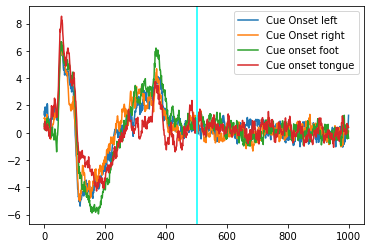

In [93]:
## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [94]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [95]:

## Preprocessing the dataset

X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_valid = tf.keras.utils.to_categorical(y_valid, 4)
y_test = tf.keras.utils.to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)





    



Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width i

## LSTM

In [ ]:

model = Sequential()
#1
model.add(LSTM(200, return_sequences=True, stateful=False,
          recurrent_dropout=0.6, dropout = 0.6, input_shape=(250, 22)))

# #2
# model.add(LSTM(100, return_sequences=True, stateful=False,
#           recurrent_dropout=0.5, dropout = 0.5))

#3
model.add(LSTM(50, return_sequences=True, stateful=False,
          recurrent_dropout=0.4, dropout = 0.4))
model.add(Flatten())

#4
model.add(Dense(100))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#5
model.add(Dense(4, activation='softmax'))



In [ ]:
# Model parameters
learning_rate = 1e-3
epochs = 40
cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:

# Model parameters
learning_rate = 1e-3
epochs = 40
cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)


Epoch 1/40
109/109 [==============================] - 270s 2s/step - loss: 1.4291 - accuracy: 0.4389 - val_loss: 1.6241 - val_accuracy: 0.4233
Epoch 2/40
109/109 [==============================] - 261s 2s/step - loss: 1.0119 - accuracy: 0.5842 - val_loss: 1.6287 - val_accuracy: 0.4087
Epoch 3/40
109/109 [==============================] - 260s 2s/step - loss: 0.8463 - accuracy: 0.6575 - val_loss: 1.1693 - val_accuracy: 0.5240
Epoch 4/40
109/109 [==============================] - 254s 2s/step - loss: 0.7351 - accuracy: 0.7105 - val_loss: 0.6985 - val_accuracy: 0.7220
Epoch 5/40
109/109 [==============================] - 254s 2s/step - loss: 0.6341 - accuracy: 0.7555 - val_loss: 0.6366 - val_accuracy: 0.7460
Epoch 6/40
109/109 [==============================] - 255s 2s/step - loss: 0.5424 - accuracy: 0.7951 - val_loss: 0.5994 - val_accuracy: 0.7593
Epoch 7/40
109/109 [==============================] - 255s 2s/step - loss: 0.4656 - accuracy: 0.8306 - val_loss: 0.6467 - val_accuracy: 0.7427

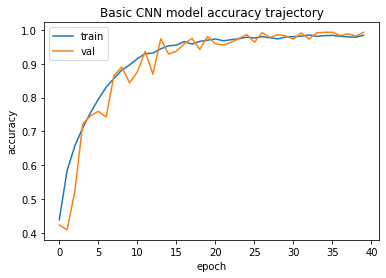

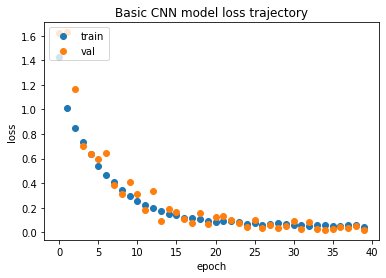

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the basic CNN model

cnn_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.5141083598136902


In [ ]:
person_test = np.load("person_test.npy")

In [ ]:
person_test=np.reshape(person_test,(person_test.shape[0],))
print(person_test.shape)

person_train_valid=np.reshape(person_train_valid,(person_train_valid.shape[0],))
print(person_train_valid.shape)

(443,)
(2115,)


In [ ]:

## Preprocessing the dataset

_ , person_test_prep = data_prep(X_test,person_test,2,2,True)

print(person_test_prep.shape)


# person_test = tf.keras.utils.to_categorical(person_test_prep, 9)
person_test= person_test_prep

print('Shape of test labels:',person_test.shape)







    



Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(1772,)
Shape of test labels: (1772,)


In [107]:
for i in range(9):    
  score_person = model.evaluate(x_test[person_test.T==i], y_test[person_test.T==i], verbose=0)  
  print("Test accuracy person " + str(i) +  " " + str(score_person[1]))        


Test accuracy person 0 0.3799999713897705
Test accuracy person 1 0.3799999713897705
Test accuracy person 2 0.6249999761581421
Test accuracy person 3 0.49499998092651365
Test accuracy person 4 0.5627659320831299
Test accuracy person 5 0.5438775777816772
Test accuracy person 6 0.5700000286102295
Test accuracy person 7 0.49499998092651365
Test accuracy person 8 0.6106382966041565


## CNN-LSTM

In [96]:
test_score_lr=[]
learning= [0.00073]
for learning_rate in learning:
      # Building the CNN model using sequential class
      basic_cnn_model = Sequential()

      # Conv. block 1
      basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='relu', input_shape=(250,1,22)))
      basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
      basic_cnn_model.add(BatchNormalization())
      basic_cnn_model.add(Dropout(0.6))

      # Conv. block 2
      basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='relu'))
      basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      basic_cnn_model.add(BatchNormalization())
      basic_cnn_model.add(Dropout(0.6))

      # Conv. block 3
      basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='relu'))
      basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      basic_cnn_model.add(BatchNormalization())
      basic_cnn_model.add(Dropout(0.6))

      # Conv. block 4
      basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='relu'))
      basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
      basic_cnn_model.add(BatchNormalization())
      basic_cnn_model.add(Dropout(0.6))



      # Output layer with Softmax activation
      basic_cnn_model.add(Flatten()) # Flattens the input

      basic_cnn_model.add(tf.keras.layers.Dense((100)))
      basic_cnn_model.add(tf.keras.layers.Reshape((100,1)))
      basic_cnn_model.add(tf.keras.layers.LSTM(20, dropout=0.6, recurrent_dropout= 0.15, input_shape=(100,1), return_sequences=False))
      basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

      basic_cnn_model.summary()


      # Model parameters
      learning_rate =  learning_rate
      epochs = 95
      cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
      # Compiling the model
      basic_cnn_model.compile(loss='categorical_crossentropy',
                      optimizer=cnn_optimizer,
                      metrics=['accuracy'])

      # Training and validating the model
      basic_cnn_model_results = basic_cnn_model.fit(x_train,
                  y_train,
                  batch_size=64,
                  epochs=epochs,
                  validation_data=(x_valid, y_valid), verbose=True)
      
      




Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_84 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_84 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_85 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_85 (MaxPoolin  (None, 28, 1, 50)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/95
109/109 [==============================] - 4s 17ms/step - loss: 1.3749 - accuracy: 0.2810 - val_loss: 1.3477 - val_accuracy: 0.3547
Epoch 2/95
109/109 [==============================] - 1s 11ms/step - loss: 1.3267 - accuracy: 0.3588 - val_loss: 1.2981 - val_accuracy: 0.3980
Epoch 3/95
109/109 [==============================] - 1s 11ms/step - loss: 1.2810 - accuracy: 0.3968 - val_loss: 1.2205 - val_accuracy: 0.4667
Epoch 4/95
109/109 [==============================] - 1s 11ms/step - loss: 1.2456 - accuracy: 0.4216 - val_loss: 1.2005 - val_accuracy: 0.4787
Epoch 5/95
109/109 [==============================] - 1s 11ms/step - loss: 1.2224 - accuracy: 0.4339 - val_loss: 1.2114 - val_accuracy: 0.4727
Epoch 6/95
109/109 [==============================] - 1s 11ms/step - loss: 1.1935 - accuracy: 0.4572 - val_loss: 1.1990 - val_accuracy: 0.4613
Epoch 7/95
109/109 [==============================] - 1s 11ms/step - loss: 1.1778 - accuracy: 0.4573 - val_loss: 1.1918 - val_accuracy: 0.4393

In [100]:
cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the CNN-LSTM model with lr {}:'.format(learning_rate),cnn_score[1])

      

Test accuracy of the CNN-LSTM model with lr 0.00073: 0.7270429110527039


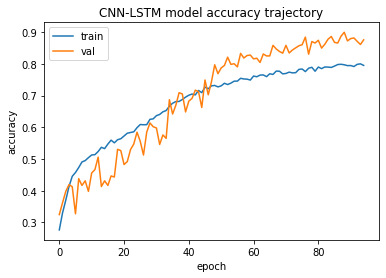

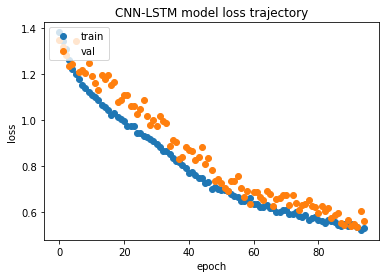

In [41]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Subject wise evaluation

In [103]:
person_test = np.load("person_test.npy")

In [104]:
person_test=np.reshape(person_test,(person_test.shape[0],))
print(person_test.shape)

person_train_valid=np.reshape(person_train_valid,(person_train_valid.shape[0],))
print(person_train_valid.shape)

(443,)
(2115,)


In [105]:

## Preprocessing the dataset

_ , person_test_prep = data_prep(X_test,person_test,2,2,True)

print(person_test_prep.shape)


# person_test = tf.keras.utils.to_categorical(person_test_prep, 9)
person_test= person_test_prep

print('Shape of test labels:',person_test.shape)







    



Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
(1772,)
Shape of test labels: (1772,)


In [47]:
for i in range(9):    
  score_person = basic_cnn_model.evaluate(x_test[person_test.T==i], y_test[person_test.T==i], verbose=0)  
  print("Test accuracy person " + str(i) +  " " + str(score_person[1]))        


Test accuracy person 0 0.6549999904632569
Test accuracy person 1 0.6049999785423279
Test accuracy person 2 0.8250000071525574
Test accuracy person 3 0.7550000143051148
Test accuracy person 4 0.8231914830207825
Test accuracy person 5 0.7291836929321289
Test accuracy person 6 0.7249999833106995
Test accuracy person 7 0.7199999880790711
Test accuracy person 8 0.791276593208313


## Subject wise training

In [ ]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid[y_train_valid==769] = 0
y_train_valid[y_train_valid==770] = 1
y_train_valid[y_train_valid==771] = 2
y_train_valid[y_train_valid==772] = 3

y_test[y_test==769] = 0
y_test[y_test==770] = 1
y_test[y_test==771] = 2
y_test[y_test==772] = 3

In [ ]:
test_score_person=[]
for idx in range(9):

    X_test = np.load("X_test.npy")
    y_test = np.load("y_test.npy")
    person_train_valid = np.load("person_train_valid.npy")
    X_train_valid = np.load("X_train_valid.npy")
    y_train_valid = np.load("y_train_valid.npy")
    person_test = np.load("person_test.npy")

    y_train_valid[y_train_valid==769] = 0
    y_train_valid[y_train_valid==770] = 1
    y_train_valid[y_train_valid==771] = 2
    y_train_valid[y_train_valid==772] = 3

    y_test[y_test==769] = 0
    y_test[y_test==770] = 1
    y_test[y_test==771] = 2
    y_test[y_test==772] = 3

    X_train_valid_sub = X_train_valid[np.where(person_train_valid == idx)[0]]
    y_train_valid_sub = y_train_valid[np.where(person_train_valid == idx)[0]]
    X_test_sub = X_test[np.where(np.squeeze(person_test) == idx)[0]]
    y_test_sub = y_test[np.where(np.squeeze(person_test) == idx)[0]]

    X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid_sub,y_train_valid_sub,2,2,True)
    X_test_prep,y_test_prep = data_prep(X_test_sub ,y_test_sub,2,2,True)


  ## Random splitting and reshaping the data
  # First generating the training and validation indices using random splitting
    ind_valid = np.random.choice(X_train_valid_sub.shape[0], 50, replace=False)
    ind_train = np.array(list(set(range(X_train_valid_sub.shape[0])).difference(set(ind_valid))))
  # Creating the training and validation sets using the generated indices
    (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid]
    (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
  # Converting the labels to categorical variables for multiclass classification
    y_train = tf.keras.utils.to_categorical(y_train, 4)
    y_valid = tf.keras.utils.to_categorical(y_valid, 4)
    y_test = tf.keras.utils.to_categorical(y_test_prep, 4)
  # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
  # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)

    # print()

    basic_cnn_model = Sequential()

    # Conv. block 1
    basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='relu', input_shape=(250,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.6))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='relu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.6))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='relu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.6))

    # Conv. block 4
    basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='relu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.6))



    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input

    basic_cnn_model.add(tf.keras.layers.Dense((100)))
    basic_cnn_model.add(tf.keras.layers.Reshape((100,1)))
    basic_cnn_model.add(tf.keras.layers.LSTM(20, dropout=0.6, input_shape=(100,1), return_sequences=False))
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    # Model parameters
    learning_rate =  learning_rate
    epochs = 95
    cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    # Compiling the model
    basic_cnn_model.compile(loss='categorical_crossentropy',
                    optimizer=cnn_optimizer,
                    metrics=['accuracy'])

    # Training and validating the model
    basic_cnn_model_results = basic_cnn_model.fit(x_train,
                y_train,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid, y_valid), verbose=True)
    
    cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
    print('Test accuracy of the CNN-LSTM model for subject {}:'.format(idx),cnn_score[1])

    test_score_person.append(cnn_score[1])

print("Test Accuracy CNN-LSTM on subject wise training:", test_score_person)


Shape of X after trimming: (237, 22, 500)
Shape of X after maxpooling: (237, 22, 250)
Shape of X after averaging+noise and concatenating: (474, 22, 250)
Shape of X after subsampling and concatenating: (948, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)

Epoch 1/95


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


3/3 [==============================] - 1s 173ms/step - loss: 2.7392 - accuracy: 0.2567 - val_loss: 4.5688 - val_accuracy: 0.3600
Epoch 2/95
3/3 [==============================] - 0s 31ms/step - loss: 2.4698 - accuracy: 0.3422 - val_loss: 4.3953 - val_accuracy: 0.3200
Epoch 3/95
3/3 [==============================] - 0s 30ms/step - loss: 2.4425 - accuracy: 0.2995 - val_loss: 4.9580 - val_accuracy: 0.2600
Epoch 4/95
3/3 [==============================] - 0s 31ms/step - loss: 2.2127 - accuracy: 0.3369 - val_loss: 5.1980 - val_accuracy: 0.2600
Epoch 5/95
3/3 [==============================] - 0s 28ms/step - loss: 2.1065 - accuracy: 0.3904 - val_loss: 4.8528 - val_accuracy: 0.3400
Epoch 6/95
3/3 [==============================] - 0s 31ms/step - loss: 1.8594 - accuracy: 0.4011 - val_loss: 4.5037 - val_accuracy: 0.3600
Epoch 7/95
3/3 [==============================] - 0s 29ms/step - loss: 1.9012 - accuracy: 0.4171 - val_loss: 4.2179 - val_accuracy: 0.4000
Epoch 8/95
3/3 [=====================

## Analysis with respect to time

In [112]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [114]:
y_train_valid[y_train_valid==769] = 0
y_train_valid[y_train_valid==770] = 1
y_train_valid[y_train_valid==771] = 2
y_train_valid[y_train_valid==772] = 3

y_test[y_test==769] = 0
y_test[y_test==770] = 1
y_test[y_test==771] = 2
y_test[y_test==772] = 3

In [115]:
# random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

y_train = tf.keras.utils.to_categorical(y_train, 4)
y_valid = tf.keras.utils.to_categorical(y_valid, 4)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)

x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)

x_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
y_test = tf.keras.utils.to_categorical(y_test, 4)

print (x_train.shape)
print (y_train.shape)
print (x_test.shape)
print (y_test.shape)
print (x_valid.shape)
print (y_valid.shape)

(1615, 1000, 1, 22)
(1615, 4)
(443, 1000, 1, 22)
(443, 4)
(500, 1000, 1, 22)
(500, 4)


In [124]:
dropout = 0.5
learning_rate = 0.00074
score_time = np.zeros(5)
time       = np.zeros(5)
for t in range(5):
    basic_cnn_model = Sequential()

    # Conv. block 1
    basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='relu', input_shape=(100 + t*200,1,22)))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.6))

    # Conv. block 2
    basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='relu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.6))

    # Conv. block 3
    basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='relu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.6))

    # Conv. block 4
    basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='relu'))
    basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    basic_cnn_model.add(BatchNormalization())
    basic_cnn_model.add(Dropout(0.6))



    # Output layer with Softmax activation
    basic_cnn_model.add(Flatten()) # Flattens the input

    basic_cnn_model.add(tf.keras.layers.Dense((100)))
    basic_cnn_model.add(tf.keras.layers.Reshape((100,1)))
    basic_cnn_model.add(tf.keras.layers.LSTM(20, dropout=0.6, input_shape=(100,1), return_sequences=False))
    basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


    # Model parameters
    learning_rate =  learning_rate
    epochs = 90
    cnn_optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    # Compiling the model
    basic_cnn_model.compile(loss='categorical_crossentropy',
                    optimizer=cnn_optimizer,
                    metrics=['accuracy'])
    
    time[t]   = 100 + t*200
    x_train_t = x_train[:,0:100 + t*200,:,:]
    x_valid_t = x_valid[:,0:100 + t*200,:,:]  

    # Training and validating the model
    basic_cnn_model_results = basic_cnn_model.fit(x_train_t,
                y_train,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid_t, y_valid), verbose=True)
    
    score_time[t] = basic_cnn_model.evaluate(x_valid_t,y_valid, verbose=0)[1]

    

Epoch 1/90


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


26/26 [==============================] - 1s 15ms/step - loss: 2.4551 - accuracy: 0.2632 - val_loss: 1.4080 - val_accuracy: 0.2900
Epoch 2/90
26/26 [==============================] - 0s 10ms/step - loss: 2.3093 - accuracy: 0.2737 - val_loss: 1.4243 - val_accuracy: 0.2960
Epoch 3/90
26/26 [==============================] - 0s 7ms/step - loss: 2.2172 - accuracy: 0.2731 - val_loss: 1.3881 - val_accuracy: 0.3060
Epoch 4/90
26/26 [==============================] - 0s 9ms/step - loss: 2.1090 - accuracy: 0.2409 - val_loss: 1.3703 - val_accuracy: 0.3080
Epoch 5/90
26/26 [==============================] - 0s 7ms/step - loss: 1.9496 - accuracy: 0.2619 - val_loss: 1.3813 - val_accuracy: 0.3100
Epoch 6/90
26/26 [==============================] - 0s 9ms/step - loss: 1.8921 - accuracy: 0.2700 - val_loss: 1.3814 - val_accuracy: 0.2780
Epoch 7/90
26/26 [==============================] - 0s 7ms/step - loss: 1.8525 - accuracy: 0.2706 - val_loss: 1.3631 - val_accuracy: 0.3120
Epoch 8/90
26/26 [===========

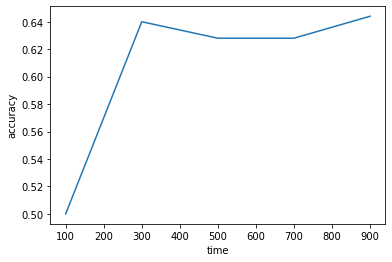

In [4]:

from matplotlib import pyplot
pyplot.ylabel('accuracy')
pyplot.xlabel('time')
pyplot.plot(time,score_time)

## Subject Identification

In [125]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [126]:
## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

print(y_train_valid)

[2 3 0 ... 3 3 2]


In [127]:
# Further break training data into train / validation sets (# put 5000 into validation set and keep remaining 55,000 for train)
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
(person_train, person_valid) = person_train_valid[ind_train], person_train_valid[ind_valid]

# Reshape input data from (22, 1000) to (28, 28, 1)
w, h = 22, 1000
x_train = x_train.reshape(x_train.shape[0], w, h)
x_valid = x_valid.reshape(x_valid.shape[0], w, h)
x_test = X_test.reshape(X_test.shape[0], w, h)

# One-hot encode the labels

#classify tasks
y_train = tf.keras.utils.to_categorical(y_train, 4)
y_valid = tf.keras.utils.to_categorical(y_valid, 4)
y_test = tf.keras.utils.to_categorical(y_test, 4)

#classify people
person_train = tf.keras.utils.to_categorical(person_train, 9)
person_valid = tf.keras.utils.to_categorical(person_valid, 9)
person_test_n = tf.keras.utils.to_categorical(person_test, 9)

# Print training set shape
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

# Print the number of training, validation, and test datasets
print(x_train.shape[0], 'train set')
print(x_valid.shape[0], 'validation set')
print(x_test.shape[0], 'test set')


x_train = np.swapaxes(x_train,2,1)
x_valid = np.swapaxes(x_valid,2,1)
x_test = np.swapaxes(x_test,2,1)

x_train = x_train.reshape(1615, h,1,w)
x_valid = x_valid.reshape(500,h, 1,w)
x_test = x_test.reshape(443,h,1,w)


x_train shape: (1615, 22, 1000) y_train shape: (1615, 4)
1615 train set
500 validation set
443 test set


In [128]:
dropout = 0.5
model = tf.keras.Sequential()

    # Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(1000,1,22))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1), strides = (3,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1), strides=(3,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(dropout))

model.add(tf.keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1), strides=(3,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(dropout))          

model.add(tf.keras.layers.Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1), strides=(3,1)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(dropout))  

model.add(tf.keras.layers.Flatten())
   
# model.add(tf.keras.layers.Dense((100)))
# model.add(tf.keras.layers.Reshape((100,1)))
# model.add(tf.keras.layers.LSTM(20, dropout=0.6, recurrent_dropout= 0.15, input_shape=(100,1), return_sequences=False))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['categorical_accuracy'])

In [129]:
history = model.fit(x_train,
         y_train,
         batch_size= 64,
         epochs=100, validation_data=(x_valid, y_valid))

Epoch 1/100
26/26 [==============================] - 2s 40ms/step - loss: 2.3439 - categorical_accuracy: 0.2824 - val_loss: 1.7872 - val_categorical_accuracy: 0.3220
Epoch 2/100
26/26 [==============================] - 0s 12ms/step - loss: 2.0445 - categorical_accuracy: 0.3331 - val_loss: 1.7655 - val_categorical_accuracy: 0.2940
Epoch 3/100
26/26 [==============================] - 0s 19ms/step - loss: 1.8320 - categorical_accuracy: 0.3678 - val_loss: 1.4951 - val_categorical_accuracy: 0.3900
Epoch 4/100
26/26 [==============================] - 0s 17ms/step - loss: 1.8258 - categorical_accuracy: 0.3393 - val_loss: 1.4274 - val_categorical_accuracy: 0.4100
Epoch 5/100
26/26 [==============================] - 1s 23ms/step - loss: 1.7113 - categorical_accuracy: 0.3709 - val_loss: 1.4976 - val_categorical_accuracy: 0.3680
Epoch 6/100
26/26 [==============================] - 1s 22ms/step - loss: 1.5915 - categorical_accuracy: 0.4074 - val_loss: 1.6162 - val_categorical_accuracy: 0.4020
Epoc

In [131]:
from tensorflow.keras.models import Model

layer_name = 'flatten_51'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
x_train_pc = intermediate_layer_model.predict(x_train)
x_valid_pc = intermediate_layer_model.predict(x_valid)
x_test_pc = intermediate_layer_model.predict(x_test)

w = x_train_pc.shape[1]
x_train_pc = x_train_pc.reshape(x_train_pc.shape[0], w, 1)
x_valid_pc = x_valid_pc.reshape(x_valid_pc.shape[0], w,1)
x_test_pc  = x_test_pc.reshape(x_test_pc.shape[0], w,1)

model1 = tf.keras.Sequential()

model1.add(tf.keras.layers.Flatten(input_shape=(w,1)))

model1.add(tf.keras.layers.Dense(200, activation='relu'))
model1.add(tf.keras.layers.Reshape((200,1)))
model1.add(tf.keras.layers.LSTM(20, dropout=0.6, recurrent_dropout= 0.15, input_shape=(200,1), return_sequences=False))
model1.add(tf.keras.layers.Dense(9, activation='softmax'))

model1.summary()


model1.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_52 (Flatten)        (None, 2400)              0         
                                                                 
 dense_74 (Dense)            (None, 200)               480200    
                                                                 
 dense_75 (Dense)            (None, 9)                 1809      
                                                                 
Total params: 482,009
Trainable params: 482,009
Non-trainable params: 0
_________________________________________________________________


In [132]:
history1 = model1.fit(x_train_pc,
         person_train,
         batch_size= 64,
         epochs=50, validation_data=(x_valid_pc, person_valid))

Epoch 1/50
26/26 [==============================] - 1s 10ms/step - loss: 1.0562 - accuracy: 0.6142 - val_loss: 0.5903 - val_accuracy: 0.7880
Epoch 2/50
26/26 [==============================] - 0s 4ms/step - loss: 0.1602 - accuracy: 0.9554 - val_loss: 0.4983 - val_accuracy: 0.8140
Epoch 3/50
26/26 [==============================] - 0s 4ms/step - loss: 0.0450 - accuracy: 0.9969 - val_loss: 0.4694 - val_accuracy: 0.8180
Epoch 4/50
26/26 [==============================] - 0s 4ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.4689 - val_accuracy: 0.8260
Epoch 5/50
26/26 [==============================] - 0s 5ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.4629 - val_accuracy: 0.8260
Epoch 6/50
26/26 [==============================] - 0s 4ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 0.4625 - val_accuracy: 0.8380
Epoch 7/50
26/26 [==============================] - 0s 4ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.4601 - val_accuracy: 0.8360
Epoch 8/50
26/26 [=

In [133]:
score = model1.evaluate(x_valid_pc, person_valid)
print (score[1])

16/16 [==============================] - 0s 2ms/step - loss: 0.4929 - accuracy: 0.8500
0.8500000238418579


In [134]:
model2 = tf.keras.Sequential()

model2.add(tf.keras.layers.Conv2D(filters=25, kernel_size=(3,3), padding='same', activation='elu', input_shape=(1000,1,22)))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.3))

model2.add(tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), padding='same', activation='elu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.5))

model2.add(tf.keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
model2.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1), strides=(3,1)))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dropout(dropout))  
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(9, activation='softmax'))

model2.summary()

model2.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_208 (Conv2D)         (None, 1000, 1, 25)       4975      
                                                                 
 max_pooling2d_208 (MaxPooli  (None, 334, 1, 25)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_208 (Ba  (None, 334, 1, 25)       100       
 tchNormalization)                                               
                                                                 
 dropout_208 (Dropout)       (None, 334, 1, 25)        0         
                                                                 
 conv2d_209 (Conv2D)         (None, 334, 1, 50)        11300     
                                                                 
 max_pooling2d_209 (MaxPooli  (None, 112, 1, 50)     

In [135]:
history2 = model2.fit(x_train,
         person_train,
         batch_size= 64,
         epochs=50, validation_data=(x_valid, person_valid))

Epoch 1/50
26/26 [==============================] - 2s 41ms/step - loss: 2.1162 - accuracy: 0.3759 - val_loss: 9.1133 - val_accuracy: 0.2200
Epoch 2/50
26/26 [==============================] - 0s 11ms/step - loss: 1.1720 - accuracy: 0.6012 - val_loss: 3.1595 - val_accuracy: 0.2360
Epoch 3/50
26/26 [==============================] - 0s 11ms/step - loss: 0.7768 - accuracy: 0.7263 - val_loss: 1.5722 - val_accuracy: 0.5560
Epoch 4/50
26/26 [==============================] - 0s 11ms/step - loss: 0.5139 - accuracy: 0.8167 - val_loss: 1.2636 - val_accuracy: 0.6740
Epoch 5/50
26/26 [==============================] - 0s 11ms/step - loss: 0.4017 - accuracy: 0.8625 - val_loss: 1.4990 - val_accuracy: 0.6320
Epoch 6/50
26/26 [==============================] - 0s 12ms/step - loss: 0.3025 - accuracy: 0.8904 - val_loss: 1.6874 - val_accuracy: 0.5980
Epoch 7/50
26/26 [==============================] - 0s 12ms/step - loss: 0.2531 - accuracy: 0.9084 - val_loss: 1.9660 - val_accuracy: 0.6120
Epoch 8/50
26

In [137]:

score = model2.evaluate(x_valid, person_valid)
print (score[1])

16/16 [==============================] - 0s 15ms/step - loss: 0.4506 - accuracy: 0.9140
0.9139999747276306


## Comparison - Transfer Learning v/s Deep Learning

16/16 [==============================] - 0s 4ms/step - loss: 0.8168 - accuracy: 0.8580


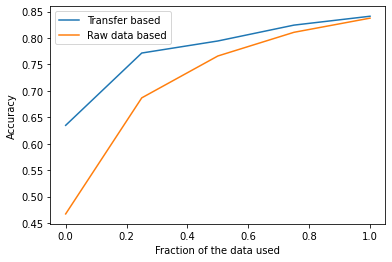

In [138]:
Niter = 5
Eval1 = np.zeros(Niter)
Eval2 = np.zeros(Niter)
Frac = np.linspace(0,1,Niter)

for iter in range(Niter):
  subset_size = x_train_pc.shape[0]*(iter+1)//Niter 
  index = np.random.choice(x_train_pc.shape[0], subset_size, replace=False)
  for m in range(5):
    model1 = tf.keras.Sequential()

    model1.add(tf.keras.layers.Flatten(input_shape=(w,1)))
  #   model1.add(tf.keras.layers.Dense(200, activation='relu'))
    model1.add(tf.keras.layers.Dense(9, activation='softmax'))

#     model1.summary()


    model1.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])

    history1 = model1.fit(x_train_pc[index],
           person_train[index],
           batch_size= 64,
           epochs=50, validation_data=(x_valid_pc, person_valid), verbose=False) 
    model2 = tf.keras.Sequential()

    model2.add(tf.keras.layers.Conv2D(filters=25, kernel_size=(3,3), padding='same', activation='elu', input_shape=(1000,1,22)))
    model2.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same'))
    model2.add(tf.keras.layers.BatchNormalization())
    model2.add(tf.keras.layers.Dropout(0.3))

    #model.add(tf.keras.layers.Conv2D(filters=50, kernel_size=(10,25), padding='same', activation=''))
    model2.add(tf.keras.layers.Conv2D(filters=50, kernel_size=(3,3), padding='same', activation='elu'))
    model2.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same'))
    model2.add(tf.keras.layers.BatchNormalization())
    model2.add(tf.keras.layers.Dropout(0.5))

    model2.add(tf.keras.layers.Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
    model2.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3), padding='same'))
    model2.add(tf.keras.layers.BatchNormalization())
    model2.add(tf.keras.layers.Dropout(0.5))
    model2.add(tf.keras.layers.Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
    model2.add(tf.keras.layers.MaxPooling2D(pool_size=(3,1), strides=(3,1)))
    model2.add(tf.keras.layers.BatchNormalization())
    model2.add(tf.keras.layers.Dropout(dropout))  
    model2.add(tf.keras.layers.Flatten())
    model2.add(tf.keras.layers.Dense(9, activation='softmax'))

#     model2.summary()

    model2.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    history2 = model2.fit(x_train[index],
           person_train[index],
           batch_size= 64,
           epochs=50, validation_data=(x_valid, person_valid), verbose=False)


    score1 = model1.evaluate(x_valid_pc, person_valid)
    Eval1[iter] +=      score1[1]

    score2 = model2.evaluate(x_valid, person_valid)
    Eval2[iter] +=      score2[1]  

Eval1 = Eval1/5
Eval2 = Eval2/5

Frac = np.linspace(0,1,Niter)


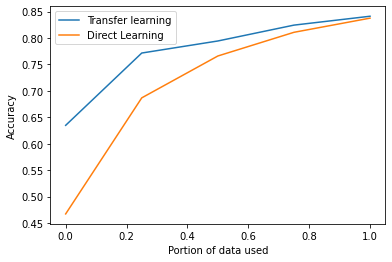

In [140]:
from matplotlib import pyplot  
pyplot.ylabel('Accuracy')
pyplot.xlabel('Portion of data used')
pyplot.plot(Frac,Eval1)   

pyplot.plot(Frac,Eval2)  
pyplot.legend(('Transfer learning','Direct Learning'))